# **Tutorial 9**


### Imports

In [1]:
import numpy as np # arrays, array operations
import scipy.stats as stats # statistics
from google.colab import files
import matplotlib.pyplot as plt # plot graphs
import pandas as pd #dataframes
import io
import xarray as xr #multidimensional dataframes
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.interpolate as interpolate

#preliz
!pip install preliz
import preliz as pz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 16.1 MB/s eta 0:00:00


### Coin Flip Example

Data

In [2]:
trials = 100
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
data

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0])

Model

In [10]:
coords = {"data": np.arange(len(data))}

with pm.Model(coords=coords) as model_1:
    thet = pm.Beta('thet', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=thet, observed=data, dims = 'data')
    idata1 = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

WAIC and LOO on our model

In [9]:
az.waic(idata1)

,0
elpd_waic,-63.684914
se,3.510919
p_waic,0.994699
n_samples,4000
n_data_points,100
warning,False
waic_i,[<xarray.DataArray 'waic_i' ()> Size: 8B\narra...
scale,log


In [12]:
print(az.loo(idata1))

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -63.69     3.51
p_loo        1.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      100  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Creating the null model

In [25]:
with pm.Model() as model_null:
    thet_null = pm.Beta('thet_null', alpha=1, beta=1) #prior
    y_null = pm.Bernoulli('y_null', p=0.5, observed=data) #likelihood
    idata_null = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})


# Compare LOO
az.compare({"alternative": idata1, "null": idata_null})

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
alternative,0,-63.686902,0.996688,0.000000,0.933441,3.511072,0.000000,False,log
null,1,-69.314671,-0.000095,5.627769,0.066559,0.000000,3.511072,True,log


In [26]:
# Compare WAIC
az.compare({"alternative": idata1, "null": idata_null}, ic = 'waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
alternative,0,-63.684914,9.946994e-01,0.000000,0.933618,3.510919,0.000000,False,log
null,1,-69.314766,2.238345e-08,5.629852,0.066382,0.000000,3.510919,False,log


### Bikes Example

In [34]:
bikes = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/bikes.csv")


,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


Linear Regression Model

In [29]:
coords = {"data": np.arange(len(bikes))}
with pm.Model(coords=coords) as model_lb:
    β0 = pm.Normal("β0", mu=0, sigma=100)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", β0 + β1 * bikes.temperature, dims="data")
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented, dims="data")
    idata_lb = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})


Output()

Negative Binomial Model

In [30]:
mu_0 = 0
sigma_0 = 1
mu_1 = 0
sigma_1 = 10
sigma_alpha = 10

with pm.Model() as model_neg:
    beta0 = pm.Normal("beta0", mu=mu_0, sigma=sigma_0)
    beta1 = pm.Normal("beta1", mu=mu_1, sigma=sigma_1)
    alpha = pm.HalfNormal("alpha", sigma=sigma_alpha)
    mu = pm.Deterministic("mu", pm.math.exp(beta0 + beta1 * bikes.temperature))
    y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=alpha, observed=bikes.rented)
    idata_neg = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})


Output()

LOO and WAIC

In [32]:
#LOO
az.compare({"linear": idata_lb, "negative_binomial": idata_neg})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
negative_binomial,0,-2153.169315,2.742507,0.000000,1.0,19.804978,0.000000,False,log
linear,1,-2300.275960,4.858970,147.106645,0.0,26.995013,21.713316,False,log


In [33]:
#WAIC
az.compare({"linear": idata_lb, "negative_binomial": idata_neg}, ic = 'waic')

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
negative_binomial,0,-2153.163883,2.737075,0.000000,1.0,19.804702,0.000000,False,log
linear,1,-2300.267411,4.850421,147.103528,0.0,26.993311,21.711993,True,log


Multiple Regression

In [35]:
with pm.Model() as model_mlb:
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 10)
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + β1 * bikes.humidity))
    _ = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)

    idata_mlb = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})


Output()

In [36]:
#LOO
az.compare({"linear": idata_lb, "negative_binomial": idata_neg, "negative_binomial_multiple": idata_mlb})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
negative_binomial_multiple,0,-2141.148332,3.725948,0.000000,1.000000e+00,20.860020,0.000000,False,log
negative_binomial,1,-2153.169315,2.742507,12.020983,0.000000e+00,19.804978,3.837865,False,log
linear,2,-2300.275960,4.858970,159.127628,2.428169e-11,26.995013,22.536404,False,log


### Model Averaging

Data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

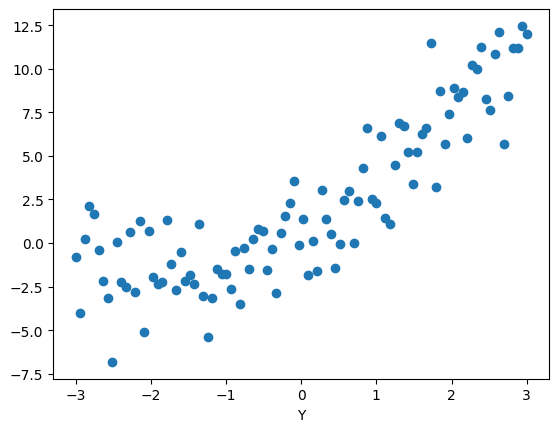

In [75]:
N = 100
x = np.linspace(-3, 3, N)
y_true = 0.5 * x**2 + 2 * x + 1
y = y_true + np.random.normal(0, 2, size=N)

plt.scatter(x, y)
plt.xlabel('X')
plt.xlabel('Y')
plt.savefig('data.png')
files.download("data.png")

Linear Model

In [104]:
with pm.Model(coords={"data": np.arange(N)}) as linear_model:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10)
    sigma = pm.HalfNormal("sigma", 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y, dims="data")

    idata_linear = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})

pm.sample_posterior_predictive(idata_linear, model=linear_model, extend_inferencedata=True)


Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

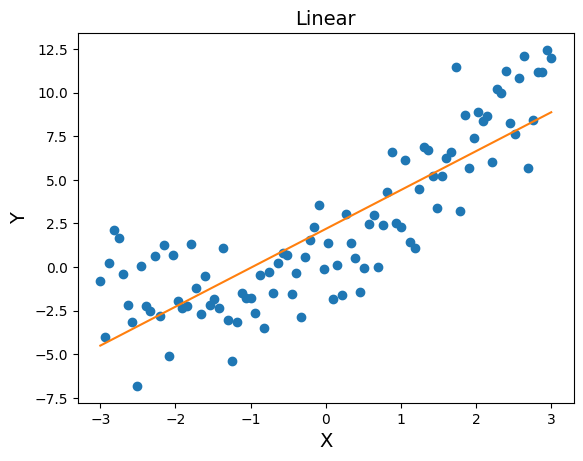

In [105]:
#plot mean
posterior = az.extract(idata_linear, num_samples=len(x))
x_plot = xr.DataArray(x)

mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot

plt.scatter(x, y)
plt.plot(x_plot, mean_line, c="C1")
plt.xlabel('X', fontsize = 14)
plt.ylabel('Y', fontsize = 14)
plt.title('Linear', fontsize = 14)


plt.savefig("lines.png", bbox_inches='tight')
files.download("lines.png")

Quadratic

In [106]:
with pm.Model(coords={"data": np.arange(N)}) as quad_model:
    x_data = pm.MutableData("x", x)
    alpha = pm.Normal("alpha", 0, 10)
    beta1 = pm.Normal("beta1", 0, 10)
    beta2 = pm.Normal("beta2", 0, 10)
    sigma = pm.HalfNormal("sigma", 5)

    mu =  pm.Deterministic('mu', alpha + beta1 * x_data + beta2 * x_data**2)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y, dims="data")

    idata_quad = pm.sample(1000, chains = 4, idata_kwargs={"log_likelihood":True})

pm.sample_posterior_predictive(idata_quad, model=quad_model, extend_inferencedata=True)



/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

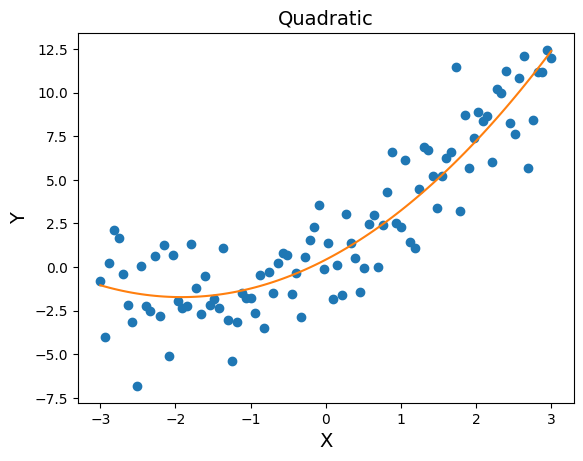

In [107]:
#plot mean
posterior = az.extract(idata_quad, num_samples=len(x))
x_plot = xr.DataArray(x)

mean_line = posterior["alpha"].mean() + posterior["beta1"].mean() * x_plot + posterior["beta2"].mean() * (x_plot**2)

plt.scatter(x, y)
plt.plot(x_plot, mean_line, c="C1")
plt.xlabel('X', fontsize = 14)
plt.ylabel('Y', fontsize = 14)
plt.title('Quadratic', fontsize = 14)


plt.savefig("q.png", bbox_inches='tight')
files.download("q.png")

Compare the Models

In [81]:
cmp_df = az.compare({"linear": idata_linear, "quadratic": idata_quad})
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
quadratic,0,-212.428280,4.036177,0.000000,0.945733,7.300654,0.000000,False,log
linear,1,-236.306868,2.944081,23.878587,0.054267,6.160884,6.660192,False,log


Averaging

In [86]:
avg_preds = az.weight_predictions([idata_linear, idata_quad], weights=cmp_df["weight"].values)

Inference data with groups:
	> posterior_predictive
	> observed_data

Plotting Results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

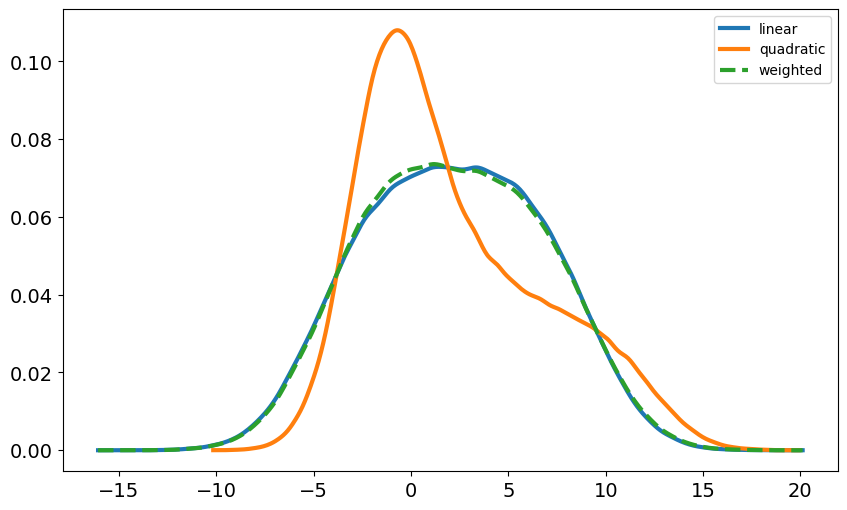

In [96]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(
    idata_linear.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)
az.plot_kde(
    idata_quad.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="quadratic",
    ax=ax,
)
az.plot_kde(
    avg_preds.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)


plt.savefig("avg.png", bbox_inches='tight')
files.download("avg.png")

We can also change the weights


In [97]:
avg_preds = az.weight_predictions([idata_linear, idata_quad], weights=[0.5, 0.5])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

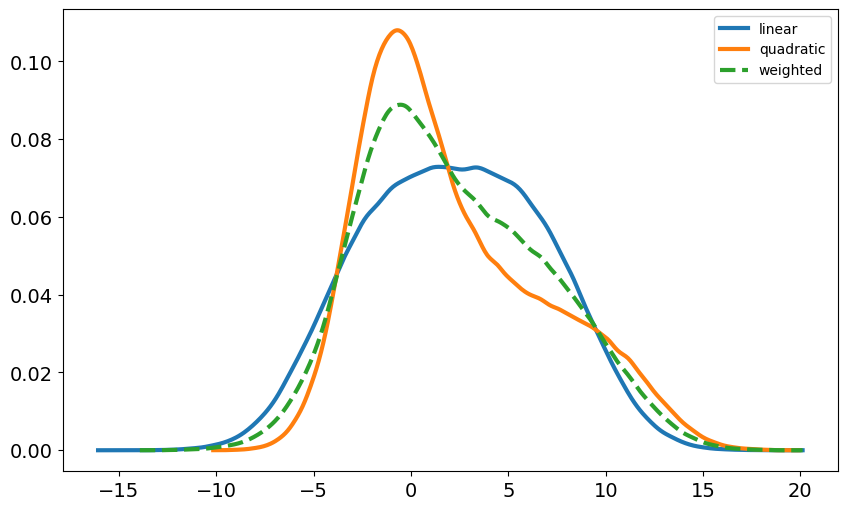

In [98]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(
    idata_linear.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)
az.plot_kde(
    idata_quad.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="quadratic",
    ax=ax,
)
az.plot_kde(
    avg_preds.posterior_predictive["y_obs"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)


plt.savefig("avg2.png", bbox_inches='tight')
files.download("avg2.png")